# INF0413 - Processamento Digital de Sinais e Imagens - A03

Neste notebook decidimos aplicar o conhecimento adquirido durante o curso ao nosso problema, principalmente, nos baseando na primeira e na segunda prova. Visto que, possuímos um problema de classificação, isto é, categorizar se um determinado áudio é deepfake ou não, vamos vamos trabalhar os conceitos de FFT e STFT a fim de, ao final, gerar um modelo de detecção de deepfakes.

<img src='https://www.popsci.com/uploads/2023/08/02/Depositphotos_203233674_L.jpg?auto=webp&width=1440&height=810' alt='image by address' height='350px'>

### Installations

In [1]:
# !pip install TTS

### Imports

In [2]:


# X = np.linspace(-0.1, 10, 20)
# y = 2 * X - 1
# plt.scatter(X, y)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/content/')
# from myAudioProcessingLib import *
import librosa

import seaborn as sns


In [4]:

import wave # <- Biblioteca para reproduzir arquivos WAV
from music21 import midi # <- Biblioteca para reproduzir arquivos MIDI
from IPython.display import Audio
# from TTS.api import TTS


In [5]:

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

### Functions


In [6]:

max_amplitude = np.iinfo('uint16').max # 2**NUM_BITS-1

def audioread(filename):
    '''
       Carrega os dados do som em um arquivo e retorna os dados no array 'soundx'
       com tipo de dado 'numpy.float', junto com a frequencia de amostragem 'fs'
       Cada canal de som será uma coluna do array.
    '''
    ifile = wave.open(filename)
    channels = ifile.getnchannels()
    fs = ifile.getframerate()
    frames = ifile.getnframes()
    x = ifile.readframes(frames)
    x = np.fromstring(x, dtype='uint16')
    x = x.astype('int16')
    x = x.astype(float) / max_amplitude
    soundx = x
    if channels > 1:
        soundx = x.reshape((int(len(x) / channels), channels))

    return soundx, fs

def play(x, fs=None):
    '''
       Reproduz arquivos de Audio (WAV, OGG)
    '''
    display(Audio(data=x, rate=fs))

def playMIDI(filename):
    '''
       Reproduz um arquivo MIDI
    '''
    mf = midi.MidiFile()
    mf.open(filename)
    mf.read()
    mf.close()
    s = midi.translate.midiFileToStream(mf)
    s.show('midi')

In [7]:
def download_database(url, filename='data_frame.csv'):
  #Funcao para fazer download da base de dados a partir da url
  # Install PyDrive

  # faz a autenticação do google drive
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  #faz o download do arquivo
  downloaded = drive.CreateFile({'id':url.split('/')[-2]})
  downloaded.GetContentFile(filename)


In [8]:
def plot_2_figures(figure1, figure2, **kwargs):
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2)

    # Plot the first figure in the first subplot
    ax1.plot(figure1)
    ax1.set_title(kwargs.get('title1', 'Subplot 1'))
    ax1.set_xlabel(kwargs.get('xlegend1', 'X-axis'))
    ax1.set_ylabel(kwargs.get('ylegend1', 'Y-axis'))

    # Plot the second figure in the second subplot
    ax2.plot(figure2)
    ax2.set_title(kwargs.get('title2', 'Subplot 2'))
    ax2.set_xlabel(kwargs.get('xlegend2', 'X-axis'))
    ax2.set_ylabel(kwargs.get('ylegend2', 'Y-axis'))

    # Display the plot
    plt.show()


from warnings import simplefilter


simplefilter('ignore')

# Set Matplotlib defaults
# plt.style.use('seaborn-whitegrid')
plt.rc('figure', autolayout=True, figsize=(12, 4))
plt.rc(
    'axes',
    labelweight='bold',
    labelsize='large',
    titleweight='bold',
    titlesize=16,
    titlepad=10,
)

%config InlineBackend.figure_format = 'retina'

## Os dados

Os dados foram coletados utilizando a voz da integrante julia dollis e do Daniel Machado.
Foram gravados vozes dela falando algumas frases e a mesma frase sendo dito utilizando um algoritmo de clonagem de voz, o TTS.

- 3 áudios
- 960 mil de tamanho
- 48000 de frequência de amostragem
- 20 segundos de audio
- Primeira metade de deepfake, segunda metade de voz real

Apenas para ilustrar o processo que utilizamos para criar as vozes clonadas, vamos demonstrá-lo a seguir.

Baixando a voz da integrante como refência...

OBS.: Os códigos relacionados ao TTS estão comentados devido a um conflito com o matplotlib, mas funcionam perfeitamente.

In [9]:

# inserir link da base de dados\faturamento
# download_database('https://drive.google.com/file/d/1hhF1p0M8LbgZIjlaGSKlGqkt86C9rVnF/view?usp=drive_link', filename='ref.wav')

In [10]:
# !gdown 1hhF1p0M8LbgZIjlaGSKlGqkt86C9rVnF

Utilizamos a voz baixada e um texto para fazer um TEXT-TO-SPEECH, assim, recebemos como saída o texto com a voz clonada.

In [11]:
# tts = TTS("tts_models/multilingual/multi-dataset/xtts_v2", gpu=False)

# # generate speech by cloning a voice using default settings
# tts.tts_to_file(text="detecção de deep fake",
#                 file_path="output_pdsi.wav",
#                 speaker_wav=["ref.wav"],
#                 language="pt",
#                 split_sentences=True
#                 )

Após isso, pegamos os áudios sintetizados, e a fala da integrante falando exatamente a mesma frase e unimos os 2 utilizando um software(audacity).

In [12]:
# Baixar o dataset
# !gdown 1kf5VaD3EWZGApMXWg9FVbY7-V-s1Kf-r
# !gdown 16bhqqOklGBXds4VlrFtrGU9BX0ziZ7nJ
# !gdown 1h83rahAWk0ZKCJj5wdqGgvJDucbYUStv

download_database('https://drive.google.com/file/d/1kf5VaD3EWZGApMXWg9FVbY7-V-s1Kf-r/view?usp=drive_link', filename='audio_junto_20s.wav')
download_database('https://drive.google.com/file/d/1h83rahAWk0ZKCJj5wdqGgvJDucbYUStv/view?usp=drive_link', filename='audio_junto_20s2.wav')
download_database('https://drive.google.com/file/d/1Uuww9kXY86J6NLn6H0mfylQW2HT0Z7QC/view?usp=sharing', filename='audio_junto_20s3.wav')


In [13]:
# Carregar o arquivo wav
x1, fs1 = librosa.load('/content/audio_junto_20s.wav', sr=None)
x2, fs2 = librosa.load('/content/audio_junto_20s2.wav', sr=None)
x3, fs3 = librosa.load('/content/audio_junto_20s3.wav', sr=None)


assert fs1 == fs2 == fs3

fs = fs1

## Análise exploratória

Nesta sessão, vamos investigar um pouco como uma pequena janela de tempo comporta no domínio do tempo comparado com o domínio da frequência. Mas antes disso, vamos analisar as ondas de som no áudio original.


### Visualizando os dados

Vamos dar início a nossa exploração de dados!

Um dos primeiros conhecimentos que vemos durante a matéria foi a plotagem dos áudios.

Então, vamos ver(rsrs) a voz da Julia.

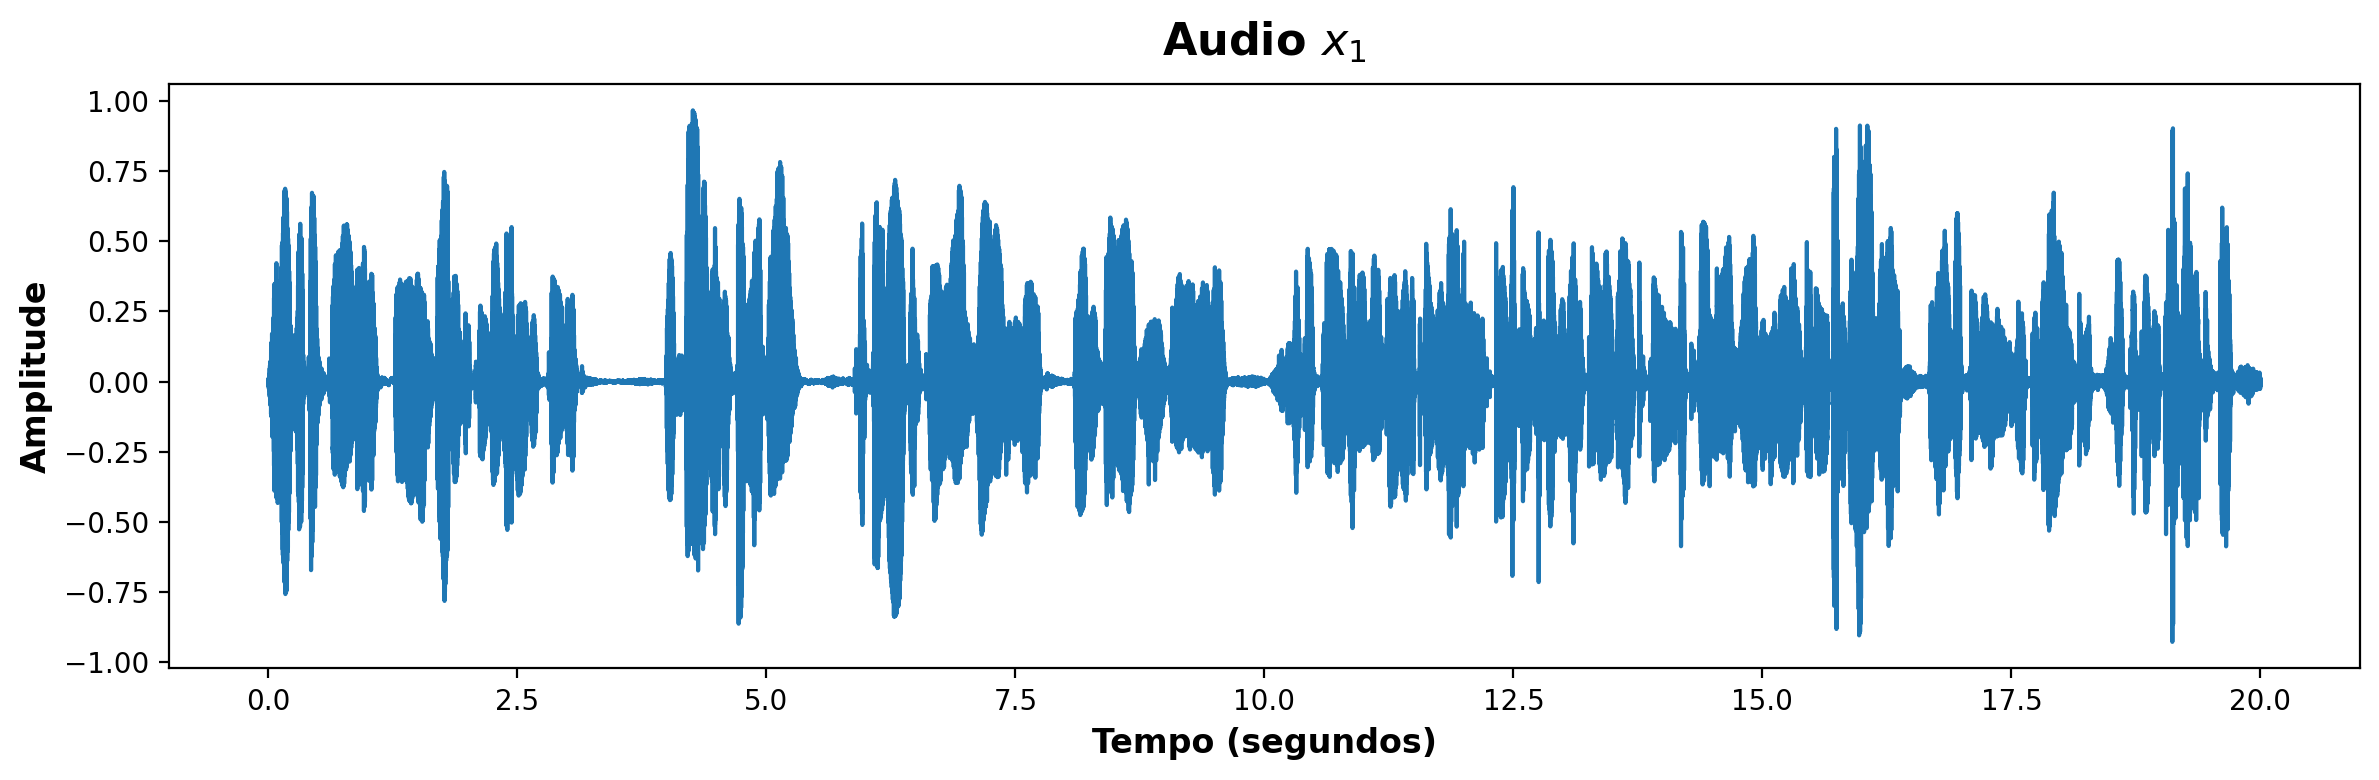

In [14]:
# Criando o vetor de tempo
N1 = len(x1)
n = np.arange(N1)
t = n / fs

# Plotagem do sinal de audio
plt.plot(t, x1)
plt.title(r'Audio $x_1$')
plt.xlabel('Tempo (segundos)')
plt.ylabel('Amplitude')
plt.show()

Assim como na A01, a primeira metade do áudio consta uma classe, nesse caso, áudio gerado, e na segunda um áudio real.

Agora, vamos ouví-los!

In [15]:
play(x1, fs)

In [16]:
play(x2, fs)

In [17]:
play(x3, fs)

E será como esses áudios ficarão se vermos eles um pouco mais de perto?

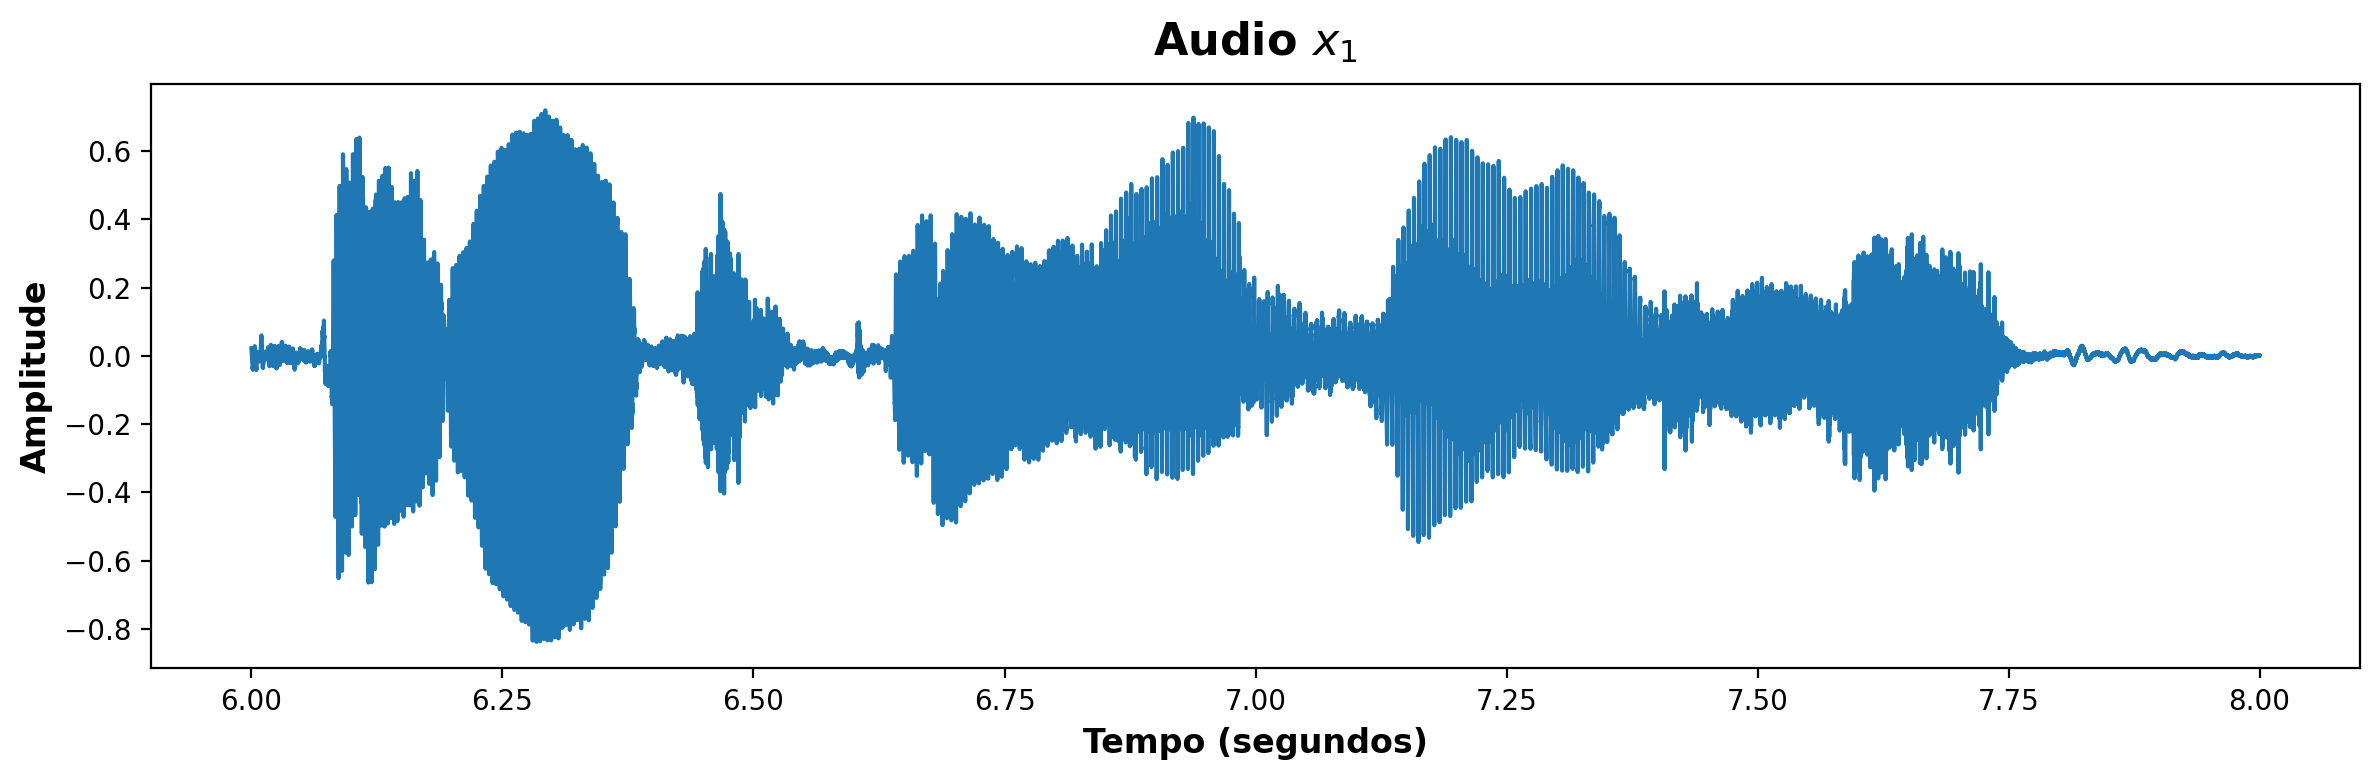

In [18]:
t = np.linspace(6, 8, fs*2)

plt.plot(t, x1[6*fs:8*fs])
plt.title(r'Audio $x_1$')
plt.xlabel('Tempo (segundos)')
plt.ylabel('Amplitude')
plt.show()

MAIS PERTO!

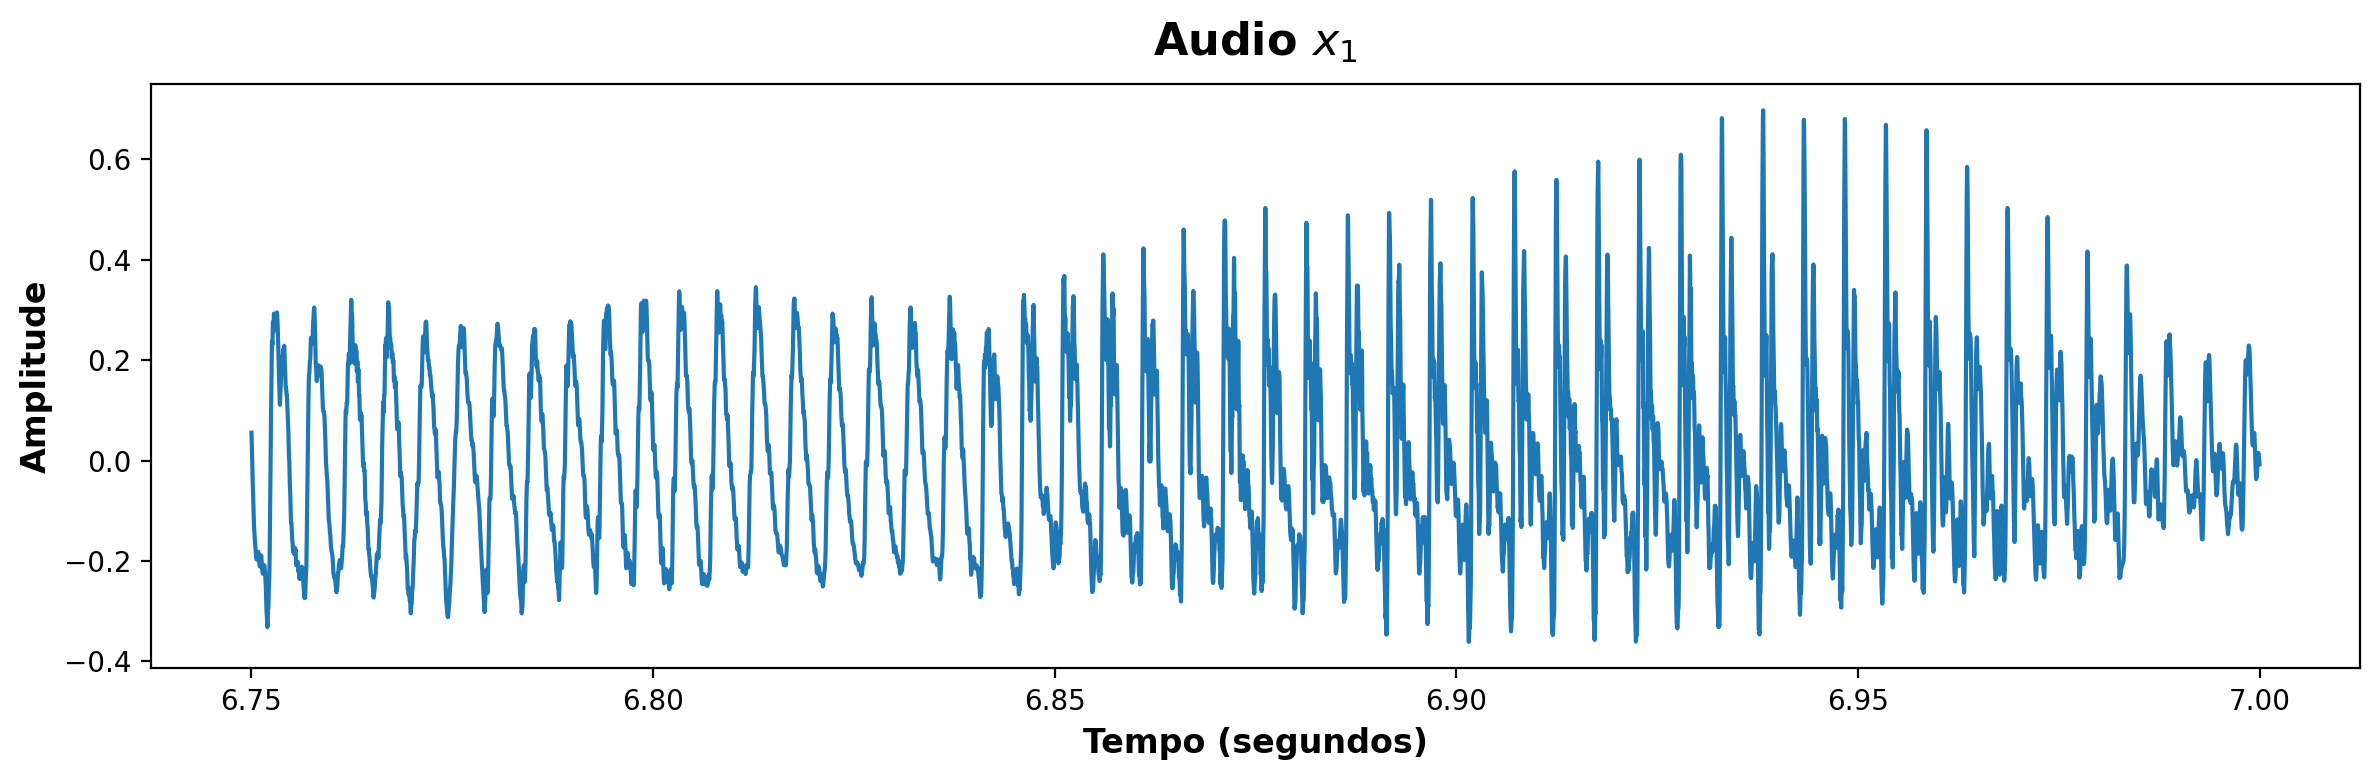

In [19]:
t = np.linspace(6.75, 7, int(fs*(7 - 6.75)))


plt.plot(t, x1[int(6.75*fs):int(7*fs)])
plt.title(r'Audio $x_1$')
plt.xlabel('Tempo (segundos)')
plt.ylabel('Amplitude')
plt.show()

AINDA MAIS PERTO!


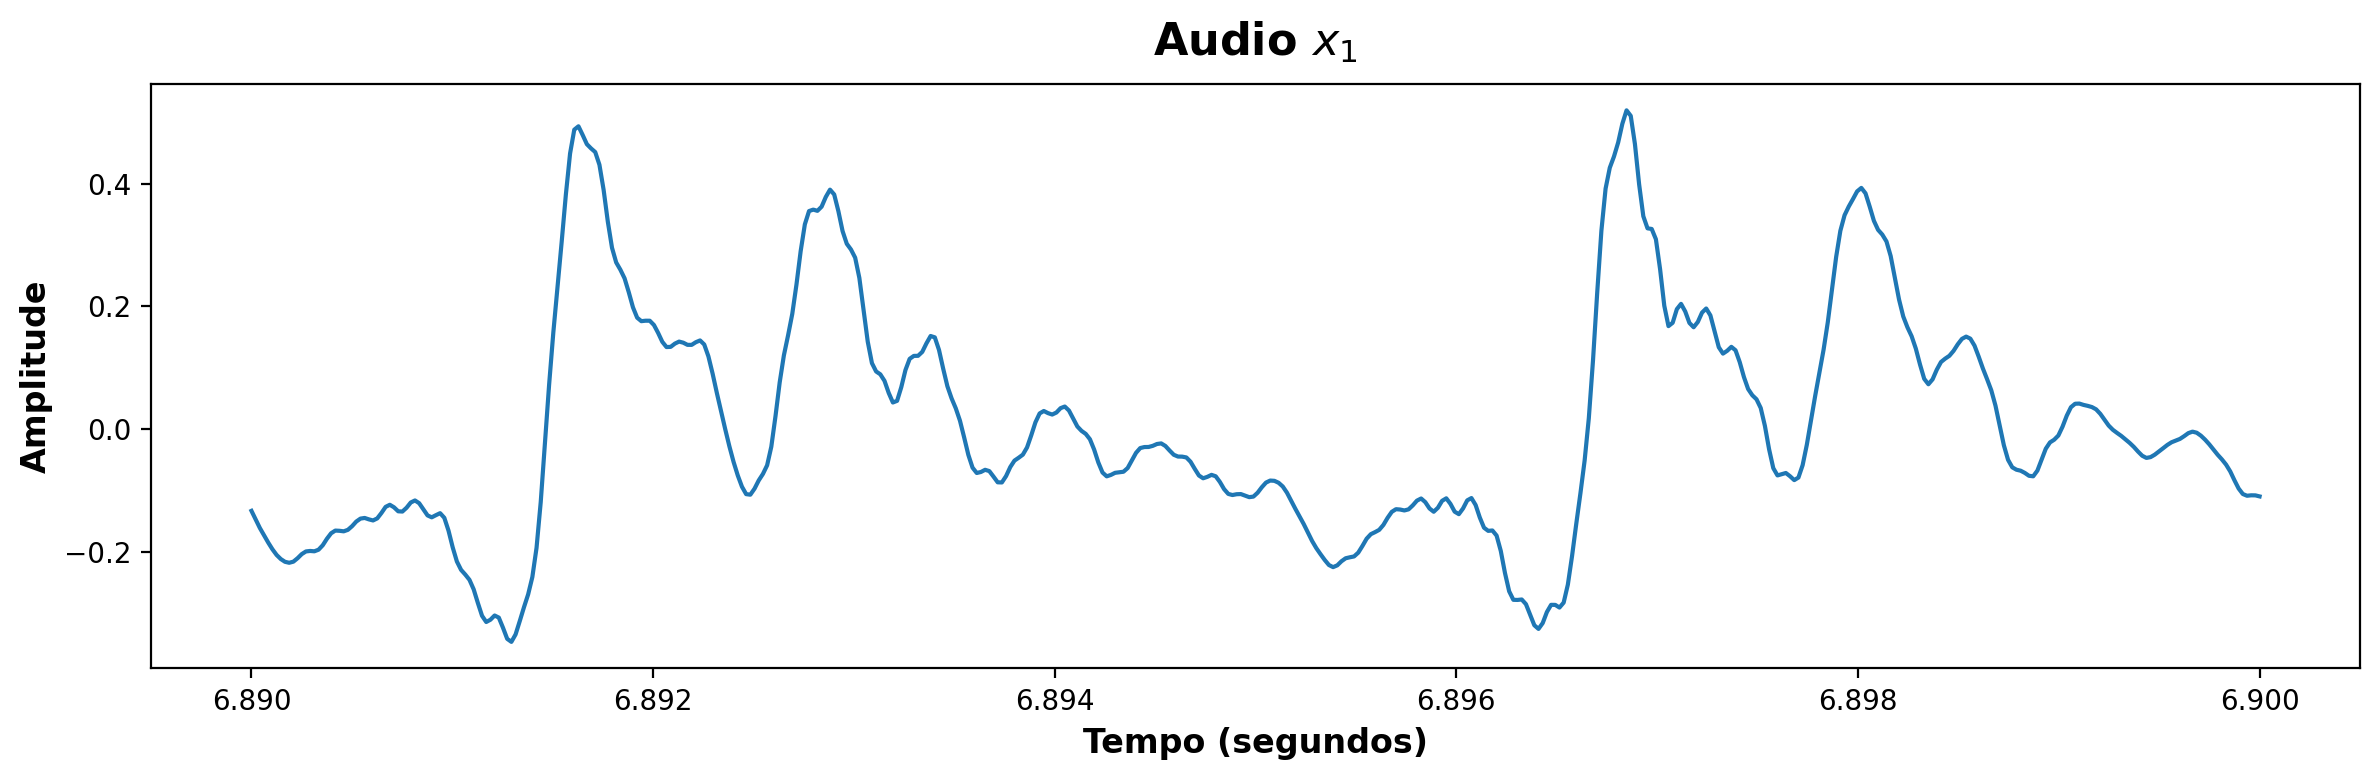

In [20]:
t = np.linspace(6.89, 6.9, int(fs*(6.9 - 6.89)))

plt.plot(t, x1[int(6.89*fs):int(6.9*fs)])
plt.title(r'Audio $x_1$')
plt.xlabel('Tempo (segundos)')
plt.ylabel('Amplitude')
plt.show()

### Domínio do Tempo VS Domínio da Frequência

O eixo $x$ da imagem que você plotou representa o tempo.
Porém, como vimos nas aulas, este não é o único modo de representar um sinal.
Ao invés de mostrar a intensidade do áudio ao longo do tempo, podemos mostrar as frequências que compoem o sinal original.
Deste modo, podemos analisar melhor a informação das características periódicas presentes no áudio em análise.



Agora, vamos relembrar o primeiro GRANDE DESAFIO que tivemos.

TRANSFORMADA DE FOURIER!


In [21]:
data = x1

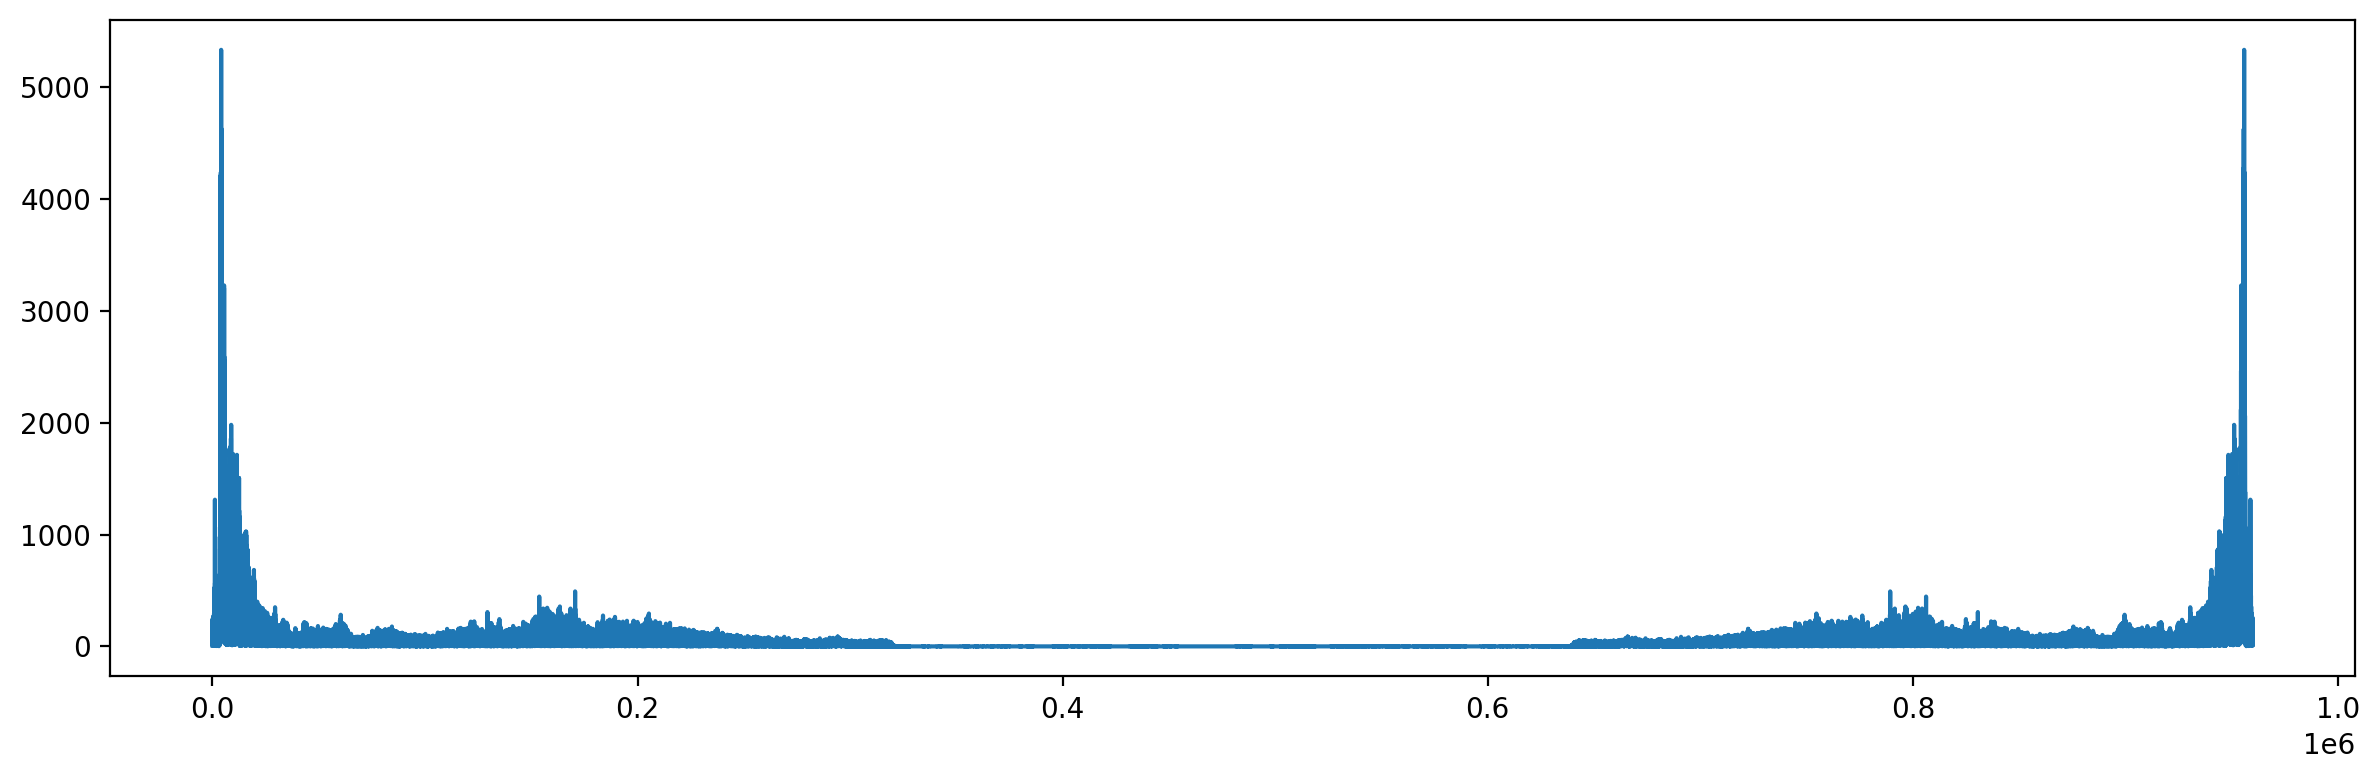

In [22]:
magnitude = np.abs(np.fft.fft(data))
plt.plot(magnitude)

Agora vamos visualizar o sinal em hertz

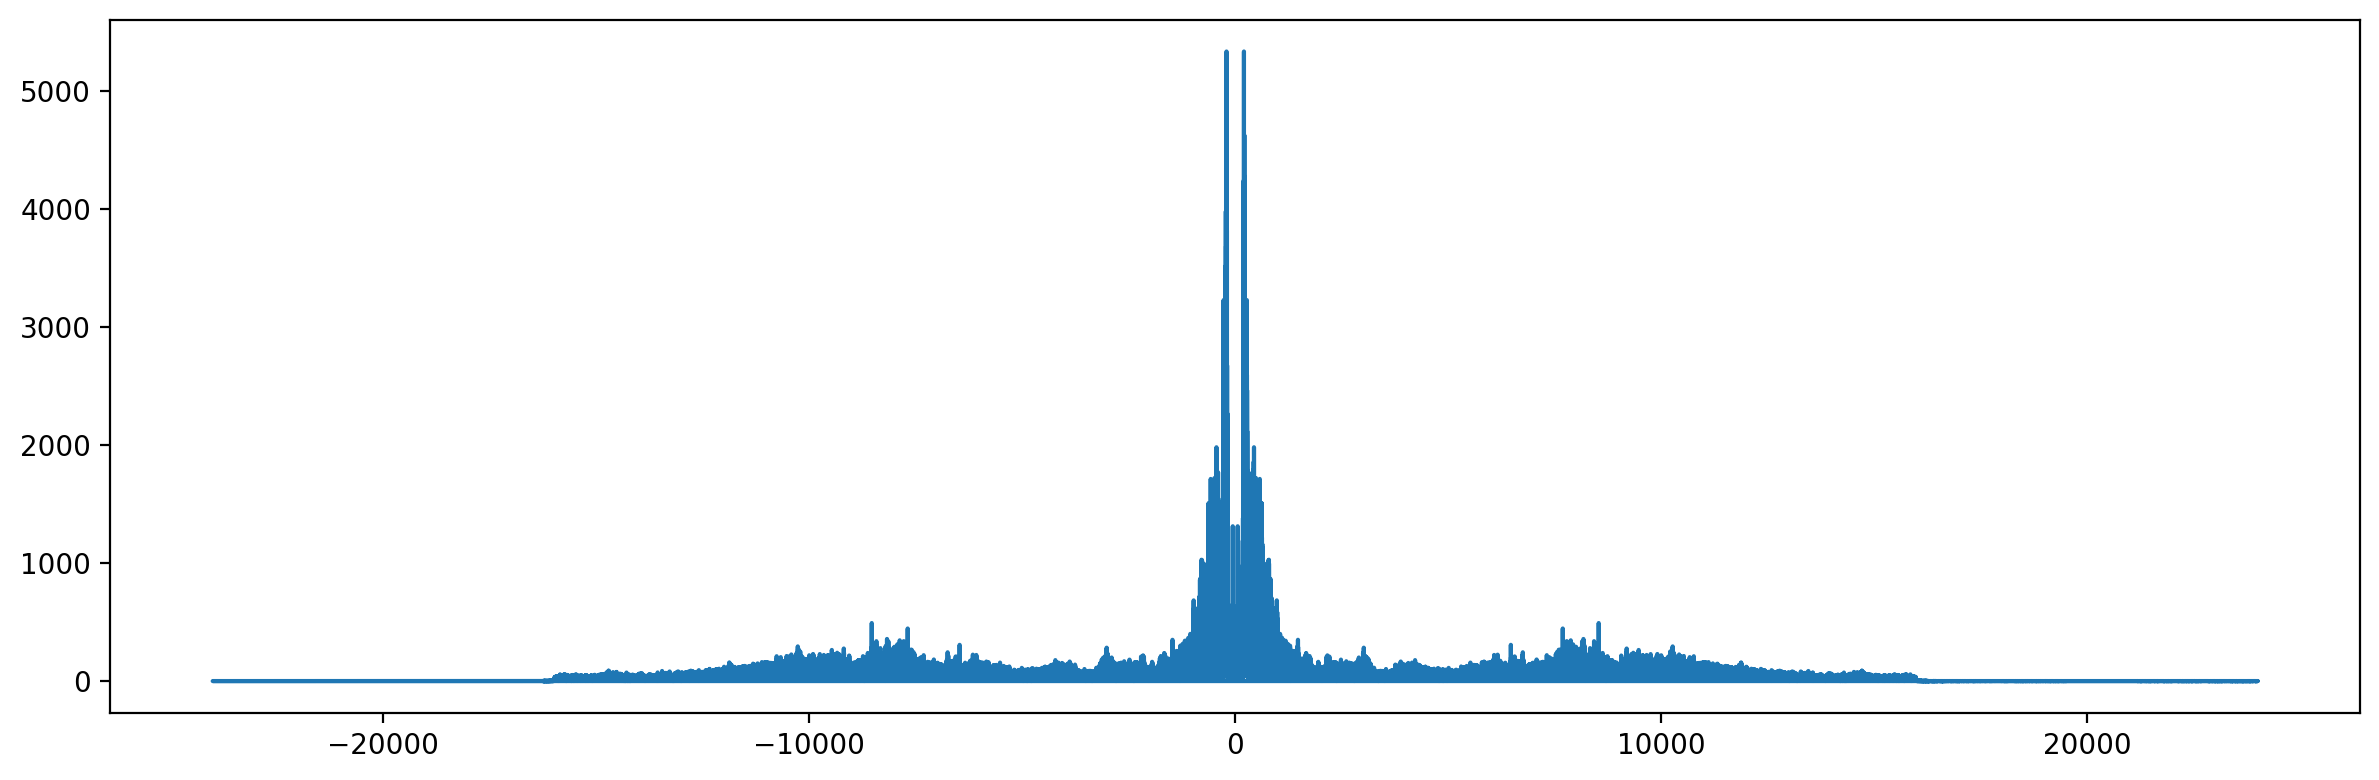

In [23]:
data = x1
freq = np.fft.fftfreq(len(x1), 1/ fs)
magnitude = np.abs(np.fft.fft(data))

plt.plot(freq, magnitude)

Os picos no grafico (maior amplitude) indicam as frequencias que possuem mais influencia na composição final do sinal. Ou seja, as frequencias com maior amplitude possuem maior "significancia" no sinal.

## STFT e Espectogramas

O nosso SEGUNDO GRANDE DESAFIO, vamos ver como ficam nossos áudios aplicado a ele...

In [24]:
# Obter STFT e plotar
def STFT(sinal, tamanho_janela=256, tamanho_passo=128):
    '''
        Calcula a STFT de um sinal.
        Parâmetros:
        - sinal: np.array
            O sinal de entrada.
        - tamanho_janela: int
            Tamanho da janela para cada segmento.
        - tamanho_passo: int
            Número de amostras entre frames sucessivos.
        Retorna:
        - matriz_stft: np.array
            Matriz contendo os coeficientes STFT.
    '''
    num_amostras = len(sinal)
    num_janelas  = 1 + (num_amostras - tamanho_janela) // tamanho_passo

    # Prepara a função de janela (janela de Hann neste caso)
    janela = np.hanning(tamanho_janela)

    # Inicializa a matriz STFT
    matriz_stft = np.zeros((num_janelas, tamanho_janela // 2 + 1), \
                           dtype=np.complex128)

    # Calcula a STFT
    for k in range(num_janelas):
        inicio = k * tamanho_passo
        fim = inicio + tamanho_janela
        segmento = sinal[inicio:fim]

        # Aplica a função de janela
        segmento_janelado = segmento * janela

        # Calcula a FFT
        resultado_fft = np.fft.fft(segmento_janelado)

        # Armazena apenas as frequências não negativas (até a frequência de Nyquist)
        matriz_stft[k, :] = resultado_fft[:tamanho_janela // 2 + 1]

    return abs(matriz_stft)


def plot_spectrogram(sinal, fs, titulo, tamanho_janela=256, tamanho_passo=128):
    # Calcular espectrograma
    spec_signal = STFT(sinal, \
                       tamanho_janela=tamanho_janela, \
                       tamanho_passo=tamanho_passo)

    # Calcular shape do plot
    stft_signal_shape = spec_signal.T.shape
    print(stft_signal_shape)

    # Determinar tempo do audio e frequência máxima
    audio_duration = len(sinal)/fs
    window_size = (stft_signal_shape[0] - 1)*2
    max_freq = np.fft.fftfreq(window_size, 1 / fs)[window_size// 2 - 1]

    # Determinar eixos de tempo e frequencia
    time_values = np.linspace(0, audio_duration, stft_signal_shape[1])
    frequency_values = np.linspace(0, max_freq, stft_signal_shape[0])

    # Criar mapa
    heatmap = sns.heatmap(spec_signal.T, cmap = 'viridis')

    # Inverter o mapa
    heatmap.invert_yaxis()

    # Adicione rótulos aos eixos
    plt.title('Espectrograma do Sinal')
    plt.title(titulo)
    plt.ylabel('Frequência (Hz)')
    plt.xlabel('Tempo (s)')

    # Setar eixos
    plt.xticks(np.arange(0, stft_signal_shape[1], step=stft_signal_shape[1] // 8), \
               labels=np.around(time_values[::stft_signal_shape[1] // 8], decimals=2), \
               rotation=45)
    plt.yticks(np.arange(0, stft_signal_shape[0], step=stft_signal_shape[0] // 8), \
               labels=np.around(frequency_values[::stft_signal_shape[0] // 8], decimals=2))
    plt.show()

In [25]:
data1 = x1
data2 = x2
data3 = x3

data1_F = data1[0: len(data1) //2]
data2_F = data1[0: len(data2) //2]
data3_F = data1[0: len(data3) //2]

data1_V = data1[len(data1)//2: -1]
data2_V = data1[len(data2)//2: -1]
data3_V = data1[len(data3)//2: -1]

(129, 3749)


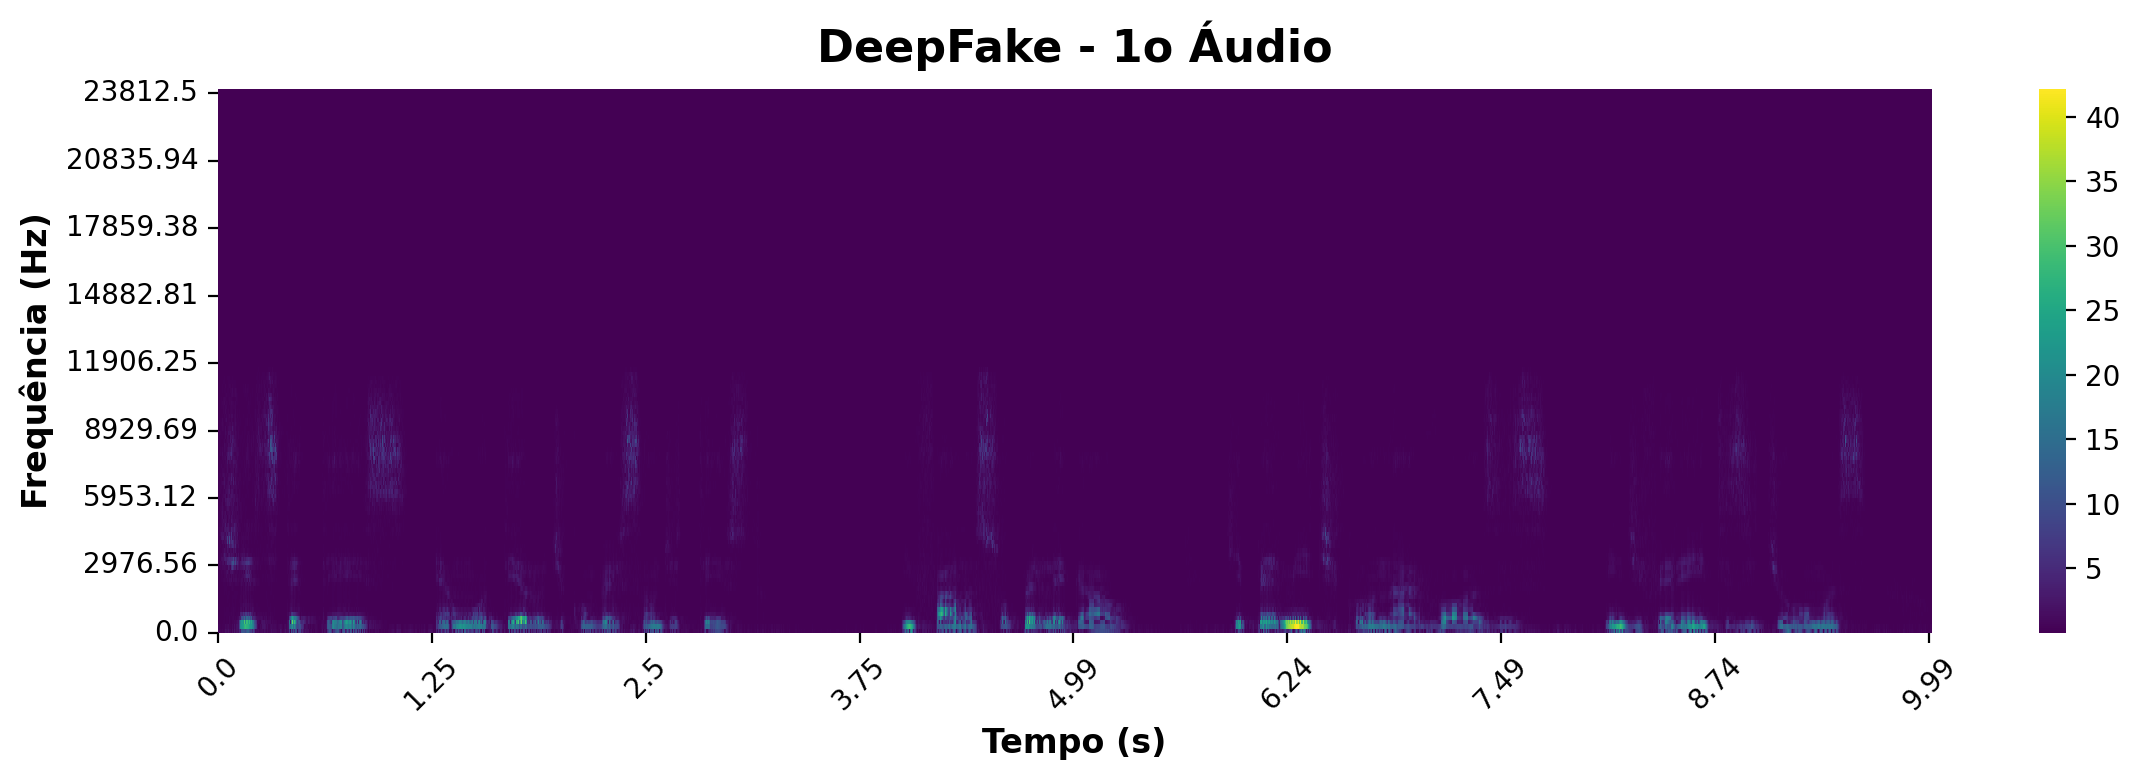

In [26]:
plot_spectrogram(data1_F, fs, "DeepFake - 1o Áudio")


(129, 3748)


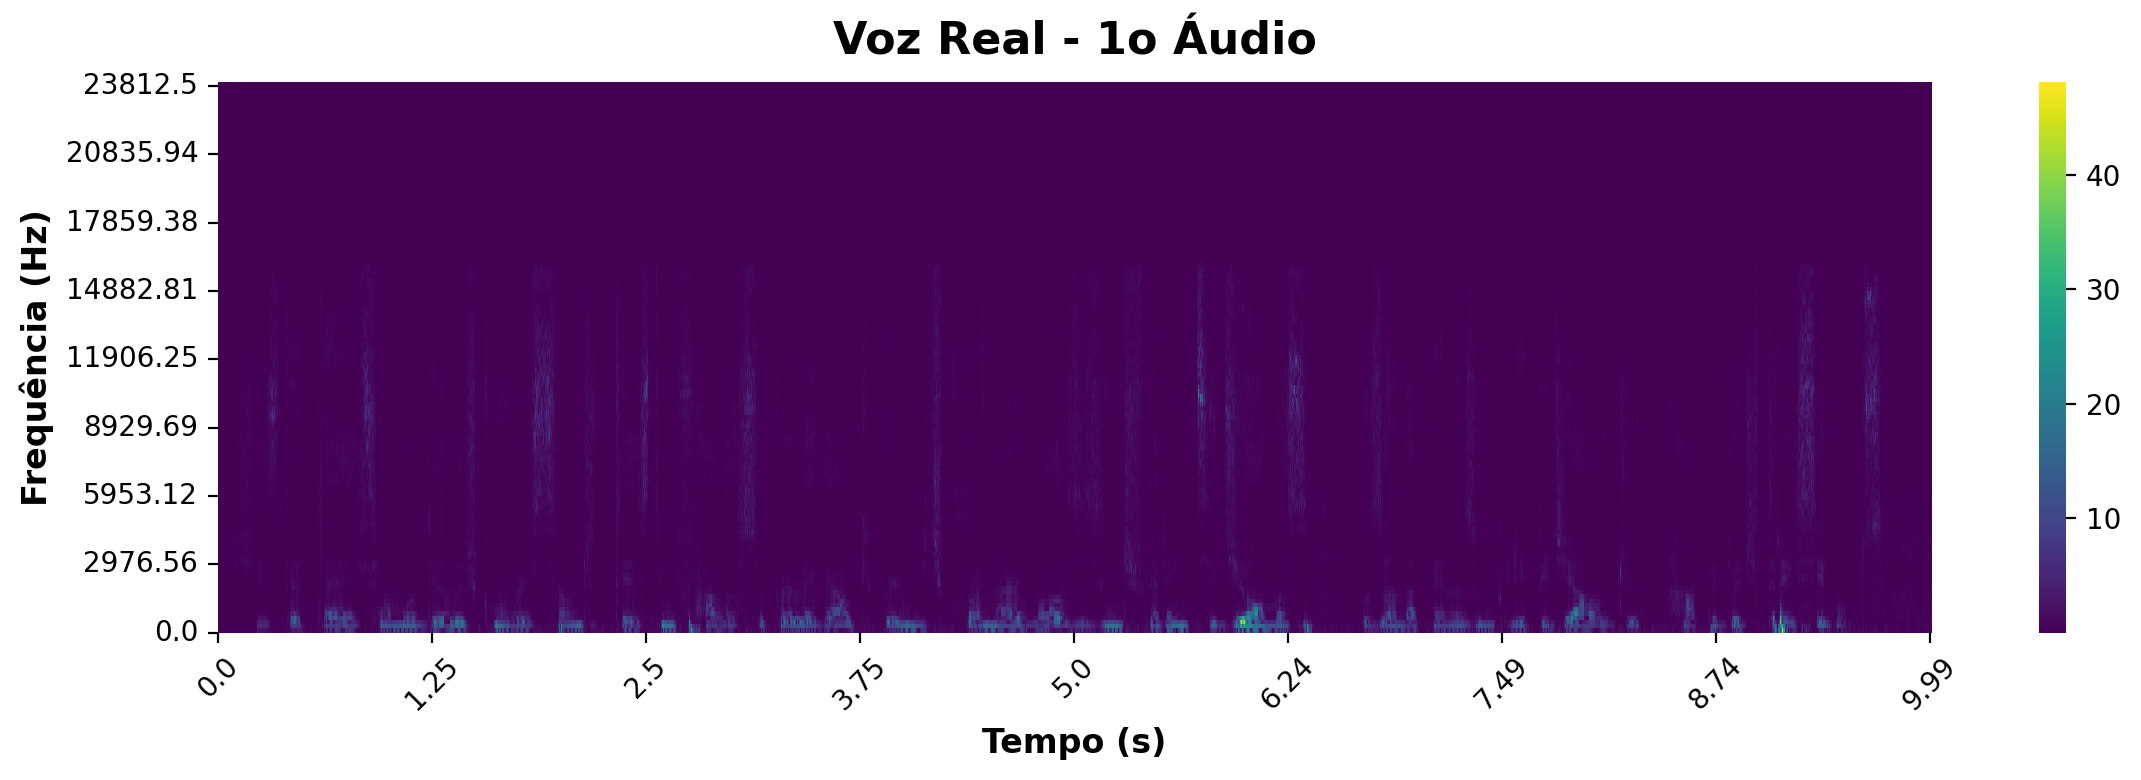

In [27]:
plot_spectrogram(data1_V, fs, "Voz Real - 1o Áudio")

## Processamento dos dados

Montagem do dataset:

Montamos um dataset com janelas de tempo de tamanho fixo e label binária ($1$ para "Voz Real" e $0$ para "Voz DeepFake").

Dividimos em várias pequenas janelas e nelas aplicamos a dft e stft, gerando assim, 2 parametros para cada amostra.

In [28]:
# Processamento das amostras com FFT e STFT
a = []  # Armazena os dados processados por FFT
t = []  # Rótulos
X_spec = []  # Armazena os dados processados por STFT

amostras = 2000  # Tamanho das amostras para FFT
for i in range(0, 50000 - amostras - 1, 1000):
    for data, label in [(data1_F, 0), (data1_V, 1), (data2_F, 0), (data2_V, 1), (data3_F, 0), (data3_V, 1)]:
        # Processamento FFT
        segmento_fft = np.abs(np.fft.fft(data[i:i+amostras]))
        a.append(segmento_fft)
        t.append(label)

        # Processamento STFT
        spec_signal = STFT(segmento_fft)
        X_spec.append(spec_signal.flatten())  # Achata o resultado da STFT para armazenamento linear

# Criação do DataFrame
df = pd.DataFrame({'fft': a, 'stft': X_spec, 'Target': t})

In [29]:
df

fft  \
0    [0.216766357421875, 3.7459387425026636, 0.9366...   
1    [0.504547119140625, 0.5893447523470897, 1.0654...   
2    [0.216766357421875, 3.7459387425026636, 0.9366...   
3    [0.504547119140625, 0.5893447523470897, 1.0654...   
4    [0.216766357421875, 3.7459387425026636, 0.9366...   
..                                                 ...   
283  [2.371978759765625, 3.9803797902647426, 1.7448...   
284  [3.714752197265625, 2.9881604036214333, 1.1581...   
285  [2.371978759765625, 3.9803797902647426, 1.7448...   
286  [3.714752197265625, 2.9881604036214333, 1.1581...   
287  [2.371978759765625, 3.9803797902647426, 1.7448...   

                                                  stft  Target  
0    [303.0263126009918, 216.5157199036886, 81.0191...       0  
1    [6.25878060823589, 3.134693755501663, 0.437682...       1  
2    [303.0263126009918, 216.5157199036886, 81.0191...       0  
3    [6.25878060823589, 3.134693755501663, 0.437682...       1  
4    [303.0263126009918, 216.5157199036886, 81.0191...       0  
..                                                 ...     ...  
283  [142.6342736114309, 91.5142299835137, 56.48930...       1  
284  [77.18832353625925, 30.96591269366499, 9.54952...       0  
285  [142.6342736114309, 91.5142299835137, 56.48930...       1  
286  [77.18832353625925, 30.96591269366499, 9.54952...       0  
287  [142.6342736114309, 91.5142299835137, 56.48930...       1  

[288 rows x 3 columns]

## Modelo

E finalmente, vamos ao modelo!

- Criar modelo

In [30]:
# Preparação das variáveis X e y
X_fft = df['fft'].tolist()  # Converte a coluna 'Amostra' para uma lista de arrays FFT
X_stft = df['stft'].tolist()  # Converte a coluna 'stft' para uma lista de arrays STFT achatados
y = df['Target'].values  # Extrai os valores da coluna 'Target' como um array numpy

# Combinando FFT e STFT em um único array numpy para X
# Supondo que você queira usar tanto os dados FFT quanto os dados STFT como características
X = np.hstack((X_fft, X_stft))  # Isso presume que X_fft e X_stft são listas de arrays do mesmo tamanho


# Se X_fft e X_stft não são simplesmente listas de números, mas sim listas de arrays,
# você precisará de uma etapa adicional para transformá-los em arrays adequados para modelagem.
# Isso pode envolver, por exemplo, garantir que todos os arrays tenham o mesmo tamanho e achatá-los.


In [31]:
from sklearn.model_selection import train_test_split

# Aqui X e y vocês teriam que criar para posteriormente separar entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [32]:
'''
Regressão Logística é um modelo simples e bom para este desafio,
mas sinta-se livre para escolher outros caso queira
'''

from sklearn.linear_model import LogisticRegression

model = LogisticRegression() # Inicializar o modelo
model.fit(X_train, y_train) # Treinar o modelo

y_pred = model.predict(X_test) # Testar o modelo

Acurácia: 1.0
Matriz de Confusão:
[[26  0]
 [ 0 32]]
Precisão: 1.0
Recall: 1.0
F1-score: 1.0
AUC: 1.0


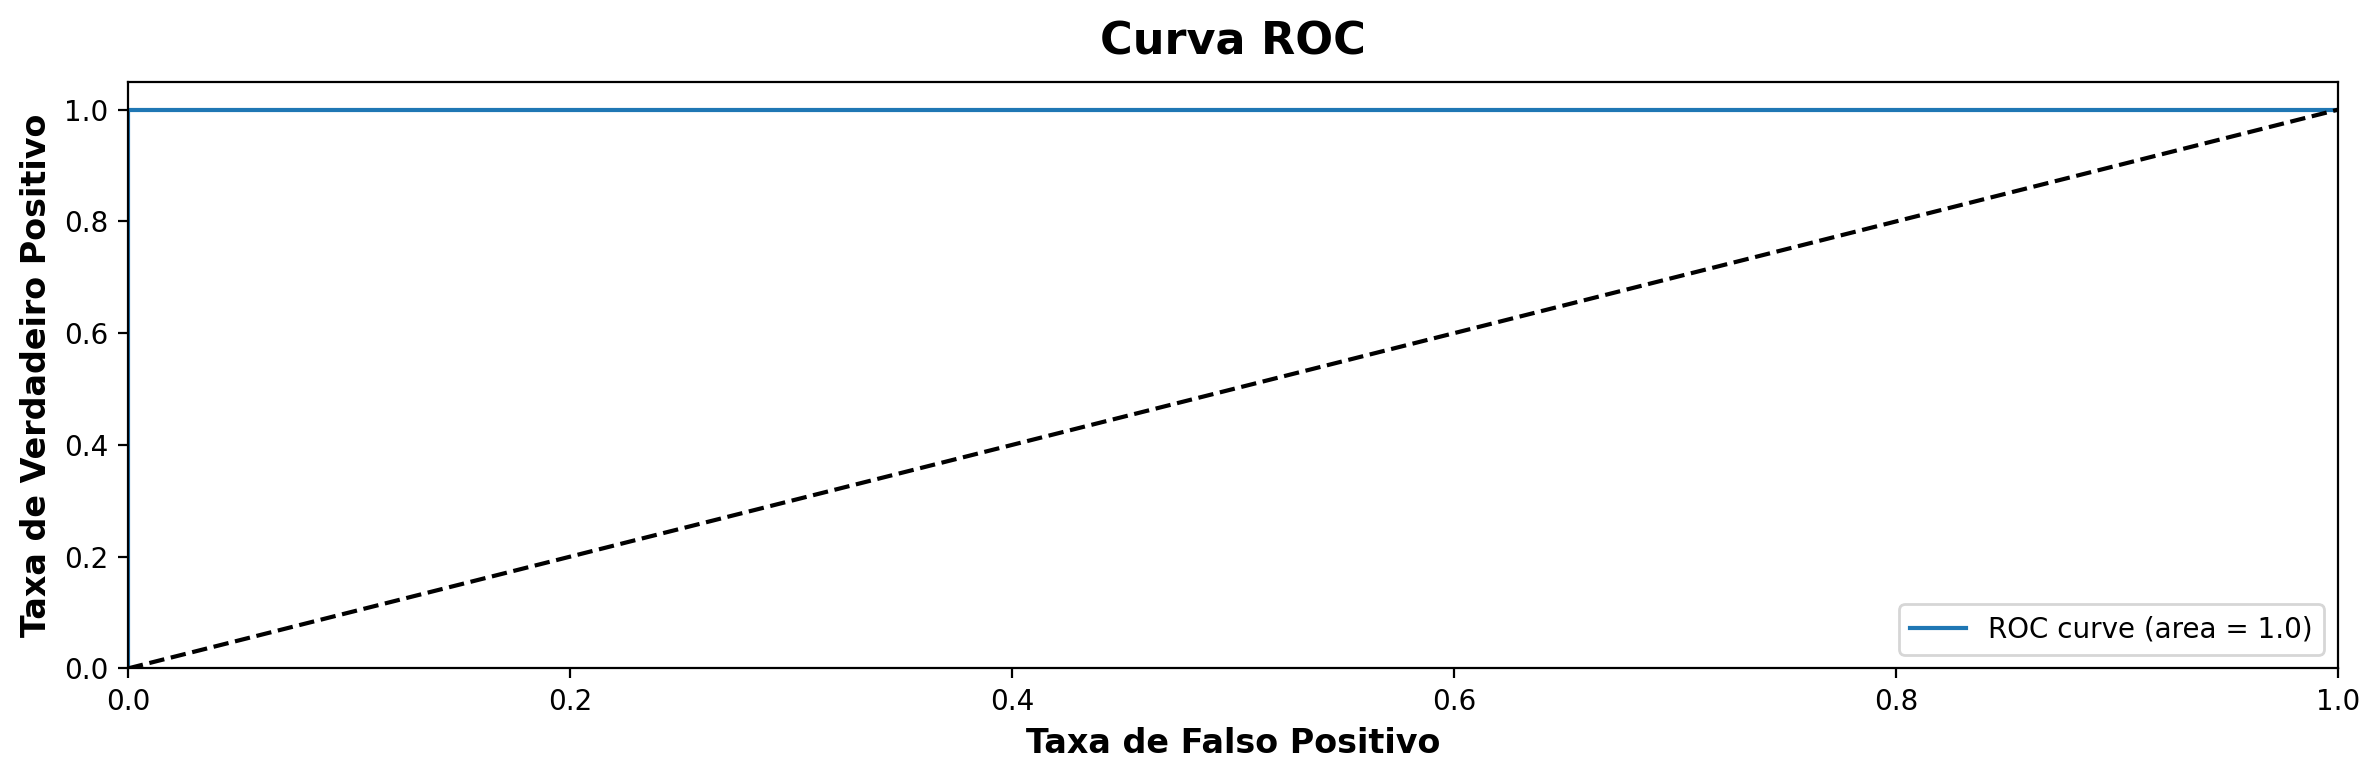

In [33]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Acurácia
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia: {accuracy}")

# Matriz de Confusão
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Matriz de Confusão:\n{conf_matrix}")

# Precisão
precision = precision_score(y_test, y_pred)
print(f"Precisão: {precision}")

# Revocação (Recall)
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall}")

# F1-score
f1 = f1_score(y_test, y_pred)
print(f"F1-score: {f1}")

# Calculando a probabilidade das previsões para usar na curva ROC e no cálculo da AUC
y_pred_prob = model.predict_proba(X_test)[:, 1]

# AUC
auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC: {auc}")

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc})')
plt.plot([0, 1], [0, 1], 'k--')  # Linha de chance
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()


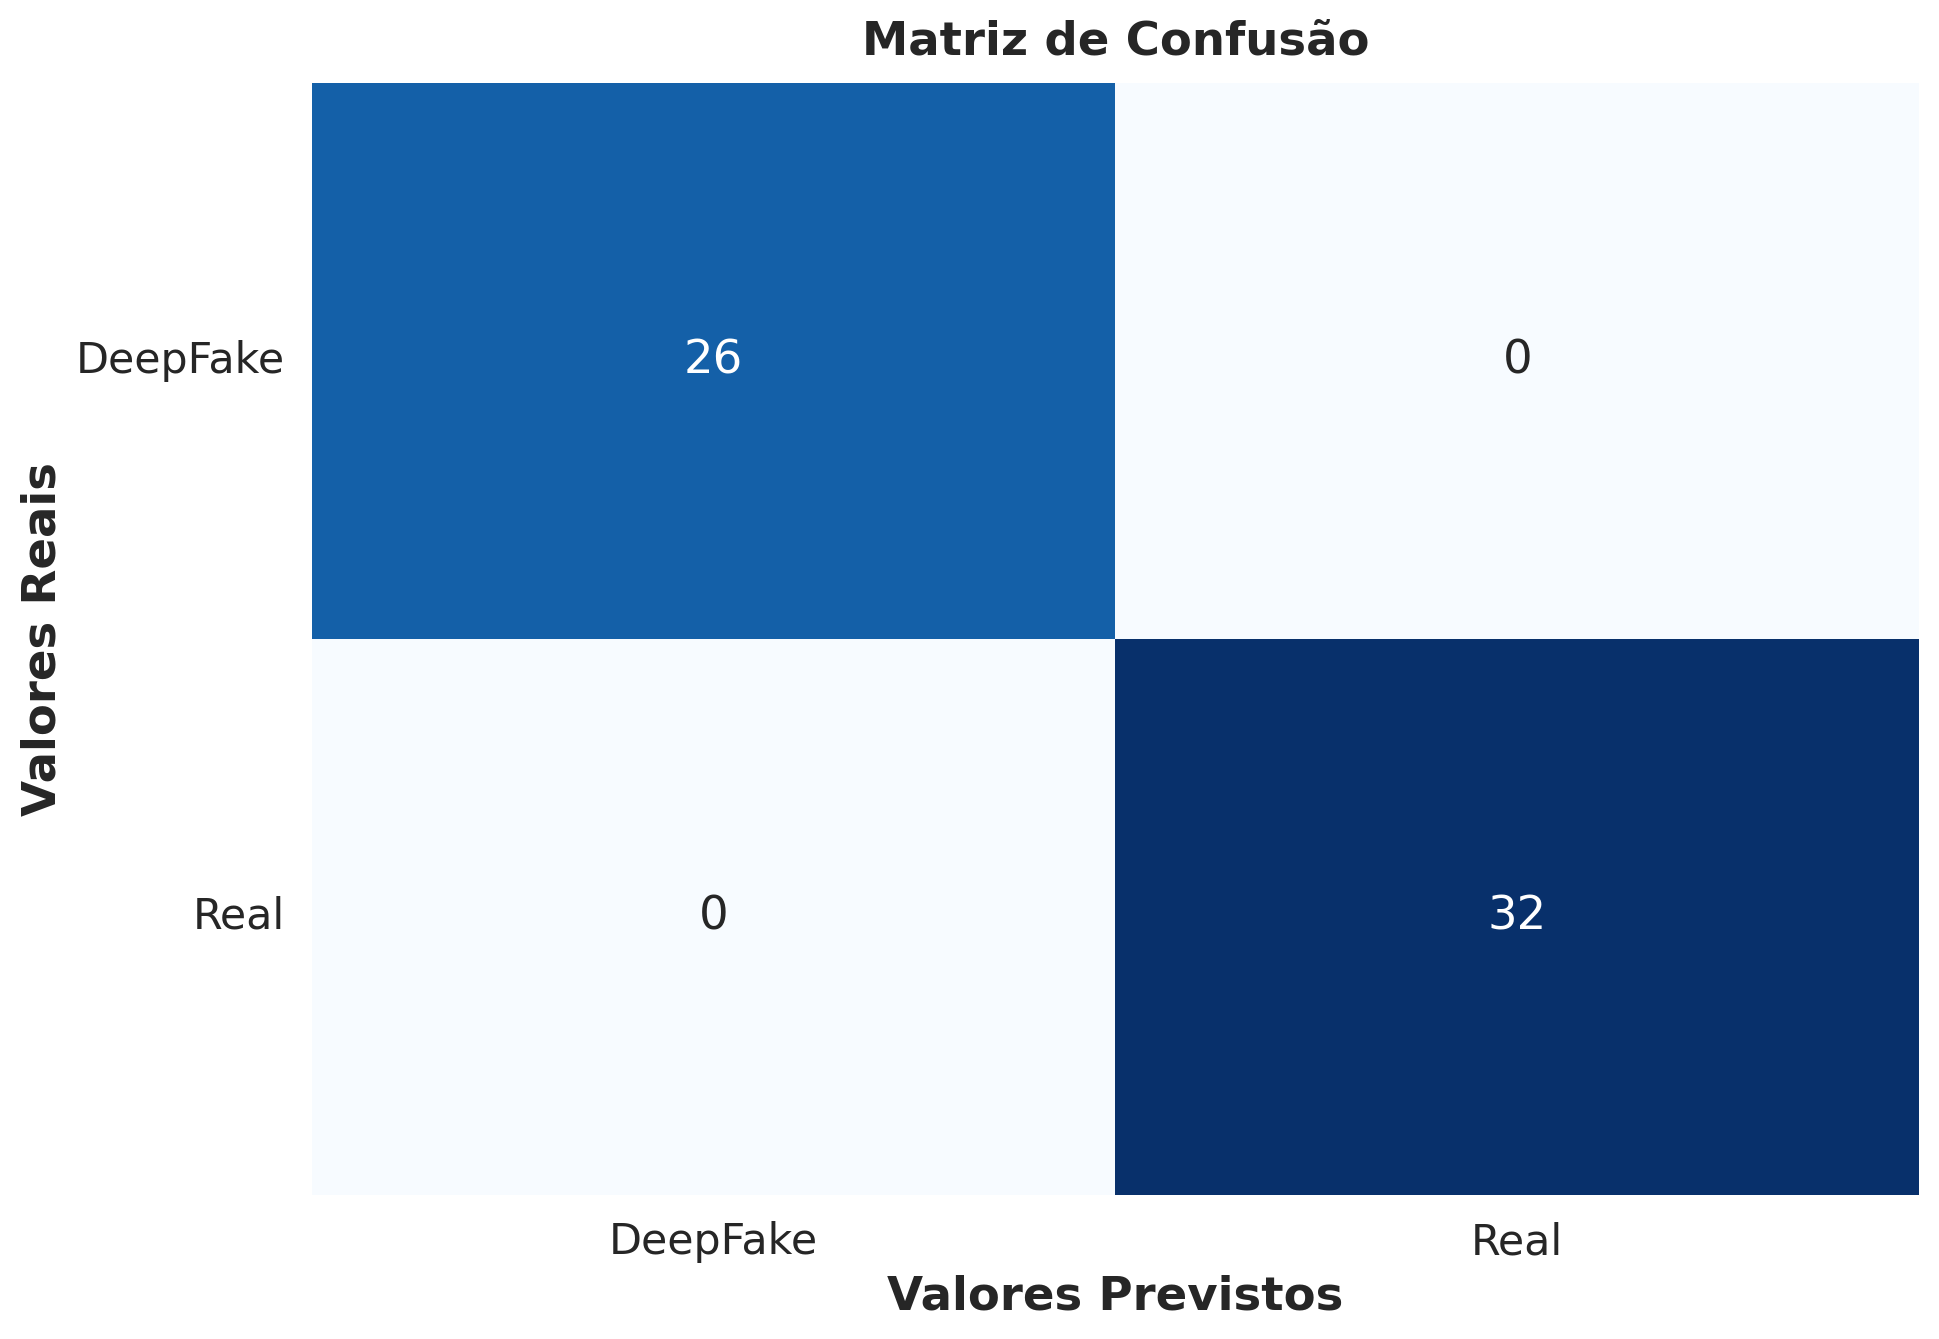

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Primeiro, calculamos a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)

# Agora, vamos plotá-la com Seaborn
plt.figure(figsize=(10, 7))
sns.set(font_scale=1.4)  # Ajusta o tamanho da fonte
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)

# Adicionando títulos e rótulos
plt.xlabel('Valores Previstos')
plt.ylabel('Valores Reais')
plt.title('Matriz de Confusão')
plt.xticks(ticks=[0.5, 1.5], labels=['DeepFake', 'Real'])  # Ajusta conforme as classes do seu modelo
plt.yticks(ticks=[0.5, 1.5], labels=['DeepFake', 'Real'], rotation=0)
plt.show()


Portanto, vemos que conseguimos treinar um modelo muito bom para resolver o nosso problema!

Mas é claro que essa métricas tão altas, provavelmente, se devem a a falta de variabilidae, isto é, nos baseamos nos áudios de apenas 2 pessoas e nos áudios gerados de um só modelo, XTTS.